In [ ]:
!pip install ipython-autotime
%load_ext autotime

# **Mise en place de l’environnement de travail**



## Installation de PySpark

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

time: 19.5 s (started: 2021-05-30 20:04:39 +00:00)


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

time: 2.61 ms (started: 2021-05-30 20:04:59 +00:00)


In [4]:
import findspark
findspark.init("spark-3.1.1-bin-hadoop2.7")

time: 3.38 ms (started: 2021-05-30 20:04:59 +00:00)


## Création de l'objet SparkContext

In [5]:
# L'objet sparkContext sc
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("ProjectApp").setMaster("local[4]")
sc = SparkContext(conf=conf)

time: 6.16 s (started: 2021-05-30 20:04:59 +00:00)


## Création de l'objet SparkSession

In [6]:
# L'objet sparkSession créé pour utiliser l'API Spark SQL
from pyspark.sql import SparkSession
spark = SparkSession.builder.config(conf=conf).getOrCreate()

time: 1.59 s (started: 2021-05-30 20:05:05 +00:00)


# **Données**

## Génération de données

In [7]:
from sklearn.datasets.samples_generator import make_blobs 

X1, y1_true = make_blobs(n_samples=1200, centers=4, n_features=2,
                       cluster_std=1.50, random_state=40)

X2, y2_true = make_blobs(n_samples=1500, centers=4, n_features=3,
                       cluster_std=1.00, random_state=41)

X3, y3_true = make_blobs(n_samples=2000, centers=4, n_features=5,
                       cluster_std=0.50, random_state=42)

time: 417 ms (started: 2021-05-30 20:05:07 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Création du RDD

In [8]:
def totupleliste(X,Y):
  t = []
  for x,y in zip(X.tolist(),Y.tolist()):
    x.append(y)
    t.append(tuple(x))
  return t

t1 = totupleliste(X1,y1_true)
t2 = totupleliste(X2,y2_true)
t3 = totupleliste(X3,y3_true)

time: 15.7 ms (started: 2021-05-30 20:05:07 +00:00)


In [9]:
rdd1 = sc.parallelize(t1)
rdd2 = sc.parallelize(t2)
rdd3 = sc.parallelize(t3)

time: 729 ms (started: 2021-05-30 20:05:07 +00:00)


## Création du Dataframe

In [10]:
deptColumns = ["x1","x2","class"]
df1 = rdd1.toDF(deptColumns)

deptColumns = ["x1","x2","x3","class"]
df2 = rdd2.toDF(deptColumns)

deptColumns = ["x1","x2","x3","x4","x5","class"]
df3 = rdd3.toDF(deptColumns)

df1.printSchema()
df1.show(truncate=False)

root
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- class: long (nullable = true)

+--------------------+-------------------+-----+
|x1                  |x2                 |class|
+--------------------+-------------------+-----+
|0.2080319426274464  |-11.44677632321588 |0    |
|7.3310176294246965  |-1.996983823103407 |1    |
|4.640867191595549   |-5.355819950141177 |1    |
|-0.6857422100702182 |-9.515901277351507 |0    |
|0.18280697659597167 |-4.034624313988483 |2    |
|-0.6550241303923521 |3.230069616391547  |3    |
|0.52935446268629    |1.9017019733897742 |3    |
|-6.21461475410652   |-9.485459117246883 |0    |
|0.8065105255722425  |3.688581698331709  |3    |
|5.518886530401512   |-1.7976214232019094|1    |
|4.643418767326436   |-5.427985411090114 |1    |
|-0.9388461464082694 |-3.217722273838516 |2    |
|-1.7466189389261682 |2.66481075818763   |3    |
|2.8408316670107663  |-1.0583788115599466|2    |
|4.60881086980905    |-3.5286741031573725|1    |
|-3.21260

# **Analyse descriptive**


In [11]:
print("Shape of data1 : " + str(X1.shape))
print("Shape of data2 : " + str(X2.shape))
print("Shape of data3 : " + str(X3.shape))

Shape of data1 : (1200, 2)
Shape of data2 : (1500, 3)
Shape of data3 : (2000, 5)
time: 4.21 ms (started: 2021-05-30 20:05:15 +00:00)


### Visualisation en utilisant les 2 premières dimensions

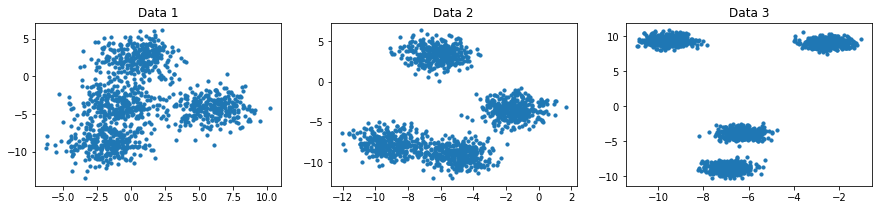

time: 857 ms (started: 2021-05-30 20:05:15 +00:00)


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))

plt.subplot(131)
plt.scatter(X1[:, 0], X1[:, 1], s=10)
plt.title("Data 1")

plt.subplot(132)
plt.scatter(X2[:, 0], X2[:, 1], s=10)
plt.title("Data 2")

plt.subplot(133)
plt.scatter(X3[:, 0], X3[:, 1], s=10)
plt.title("Data 3")

plt.savefig('analyse.png')

# **Clustering**

### En utulisant Scikit-learn

In [13]:
from sklearn.cluster import KMeans as Kmeans_sklearn_algo
def kmeans_sklearn(df):
  kmeans = Kmeans_sklearn_algo(n_clusters=4) 
  kmeans.fit(df)
  return kmeans

kmeans_sklearn1 = kmeans_sklearn(X1)
y1_kmeans_sklearn = kmeans_sklearn1.predict(X1)

kmeans_sklearn2 = kmeans_sklearn(X2)
y2_kmeans_sklearn = kmeans_sklearn2.predict(X2)

kmeans_sklearn3 = kmeans_sklearn(X3)
y3_kmeans_sklearn = kmeans_sklearn3.predict(X3)

time: 337 ms (started: 2021-05-30 20:05:16 +00:00)


Text(0.5, 1.0, 'Data 3')

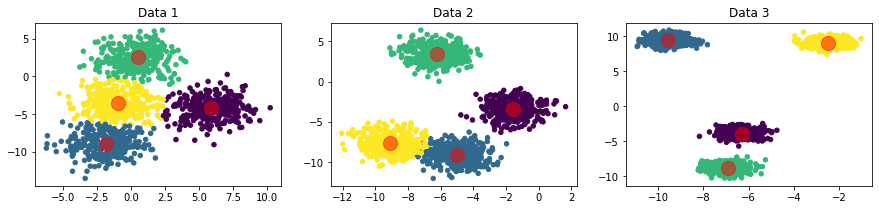

time: 844 ms (started: 2021-05-30 20:05:16 +00:00)


In [14]:
def plot_kmeans(df, model, pred):
  plt.scatter(df[:, 0], df[:, 1], c=pred, s=20, cmap='viridis')
  centers = model.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

plt.figure(figsize=(15,3))

plt.subplot(131)
plot_kmeans(X1, kmeans_sklearn1, y1_kmeans_sklearn)
plt.title("Data 1")

plt.subplot(132)
plot_kmeans(X2, kmeans_sklearn2, y2_kmeans_sklearn)
plt.title("Data 2")

plt.subplot(133)
plot_kmeans(X3, kmeans_sklearn3, y3_kmeans_sklearn)
plt.title("Data 3")


### En utilisant Spark

In [15]:
from pyspark.ml.clustering import KMeans as Kmeans_spark_algo
from pyspark.ml.feature import VectorAssembler

def kmeans_spark(df):
  vecAssembler = VectorAssembler(inputCols=["x1", "x2"], outputCol="features")
  new_df = vecAssembler.transform(df)
  kmeans = Kmeans_spark_algo(k=4, seed=1)
  model = kmeans.fit(new_df.select('features'))
  predictions = model.transform(new_df)
  return predictions

y1_kmeans_spark = kmeans_spark(df1)
y2_kmeans_spark = kmeans_spark(df2)
y3_kmeans_spark = kmeans_spark(df3)

time: 16.8 s (started: 2021-05-30 20:05:17 +00:00)


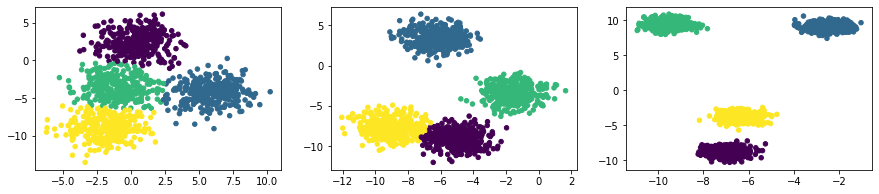

time: 1.58 s (started: 2021-05-30 20:05:34 +00:00)


In [16]:
plt.figure(figsize=(15,3))

plt.subplot(131)
y1_kmeans_spark = list(y1_kmeans_spark.select('prediction').toPandas()['prediction'])
plt.scatter(X1[:, 0], X1[:, 1], c=y1_kmeans_spark, s=20, cmap='viridis')

plt.subplot(132)
y2_kmeans_spark = list(y2_kmeans_spark.select('prediction').toPandas()['prediction'])
plt.scatter(X2[:, 0], X2[:, 1], c=y2_kmeans_spark, s=20, cmap='viridis')

plt.subplot(133)
y3_kmeans_spark = list(y3_kmeans_spark.select('prediction').toPandas()['prediction'])
plt.scatter(X3[:, 0], X3[:, 1], c=y3_kmeans_spark, s=20, cmap='viridis')

### Evaluation des performances

**Sklearn**

In [17]:
from sklearn.metrics import normalized_mutual_info_score
print("NMI - Data1 - Sklearn : " + str(normalized_mutual_info_score(y1_true, y1_kmeans_sklearn)))
print("NMI - Data2 - Sklearn : " + str(normalized_mutual_info_score(y2_true, y2_kmeans_sklearn)))
print("NMI - Data3 - Sklearn : " + str(normalized_mutual_info_score(y3_true, y3_kmeans_sklearn)))

NMI - Data1 - Sklearn : 0.8610095321297618
NMI - Data2 - Sklearn : 0.9767976507403721
NMI - Data3 - Sklearn : 1.0
time: 19.1 ms (started: 2021-05-30 20:05:35 +00:00)


**Spark**

In [18]:
print("NMI - Data1 - Spark : " + str(normalized_mutual_info_score(y1_true, y1_kmeans_spark)))
print("NMI - Data2 - Spark : " + str(normalized_mutual_info_score(y2_true, y2_kmeans_spark)))
print("NMI - Data3 - Spark : " + str(normalized_mutual_info_score(y3_true, y3_kmeans_spark)))

NMI - Data1 - Spark : 0.8610095321297617
NMI - Data2 - Spark : 0.9707339672174148
NMI - Data3 - Spark : 1.0
time: 17.6 ms (started: 2021-05-30 20:05:36 +00:00)


### Temps d'executions

**Sklearn**

In [19]:
kmeans_sklearn(X1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 91.1 ms (started: 2021-05-30 20:05:36 +00:00)


In [20]:
kmeans_sklearn(X2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 57.1 ms (started: 2021-05-30 20:05:36 +00:00)


In [21]:
kmeans_sklearn(X3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 87.5 ms (started: 2021-05-30 20:05:36 +00:00)


**Spark**

In [22]:
kmeans_spark(df1)

DataFrame[x1: double, x2: double, class: bigint, features: vector, prediction: int]

time: 2.86 s (started: 2021-05-30 20:05:36 +00:00)


In [23]:
kmeans_spark(df2)

DataFrame[x1: double, x2: double, x3: double, class: bigint, features: vector, prediction: int]

time: 2.59 s (started: 2021-05-30 20:05:39 +00:00)


In [24]:
kmeans_spark(df3)

DataFrame[x1: double, x2: double, x3: double, x4: double, x5: double, class: bigint, features: vector, prediction: int]

time: 2.42 s (started: 2021-05-30 20:05:41 +00:00)


# **Implémentation du k-means**



## Construction des fonctions

In [25]:
import numpy as np

def compute_centroids(points, cluster_ids):
  rdd = sc.parallelize(list(zip(cluster_ids, points)))
  sum_by_cluster_id = rdd.reduceByKey(lambda a,b : list(np.array(a)+np.array(b)))
  count_by_cluster_id = rdd.mapValues(lambda x : 1).reduceByKey(lambda a,b : a+b)
  joined_count_sum = sum_by_cluster_id.join(count_by_cluster_id)
  moyenne_cluster_id = joined_count_sum.map(lambda x : (x[0], list(np.array(x[1][0])/x[1][1])))

  return moyenne_cluster_id

time: 26.6 ms (started: 2021-05-30 20:05:44 +00:00)


In [26]:
def squared_distances(point, moyennes):
  sq = pow((np.array(moyennes) - point), 2)

  if sq.ndim==1:  #cas unidimentionnel
    return list(sq)
  else:           #cas bidimentionnel
    return list(np.sum(sq,axis=1))

time: 4.85 ms (started: 2021-05-30 20:05:44 +00:00)


In [27]:
def assign_clusters(points, centroids):
  cds = centroids.collect()
  moyennes = [m for c,m in cds]
  pts = []
  for p in points:
    sq_dist = squared_distances(p, moyennes)
    pts.append(np.argmin(sq_dist))
  rdd_assign = sc.parallelize(pts)
  return rdd_assign

time: 12.3 ms (started: 2021-05-30 20:05:44 +00:00)


In [51]:
def k_means(data, k, maxIter=256):
  clusters = sc.parallelize(np.random.randint(size=len(data), low=0, high=k))
  cl = clusters.collect()
  for n in range(maxIter):
    centroids = compute_centroids(data, clusters.collect())
    clusters = assign_clusters(data, centroids)
    if cl==clusters.collect():
      break
    else:
      cl = list(clusters.collect())
  return clusters

time: 8.98 ms (started: 2021-05-30 20:08:01 +00:00)


In [52]:
y1_kmeans_ours = k_means(X1,k=4)
y2_kmeans_ours = k_means(X2,k=4)
y3_kmeans_ours = k_means(X3,k=4)

time: 6.74 s (started: 2021-05-30 20:08:01 +00:00)


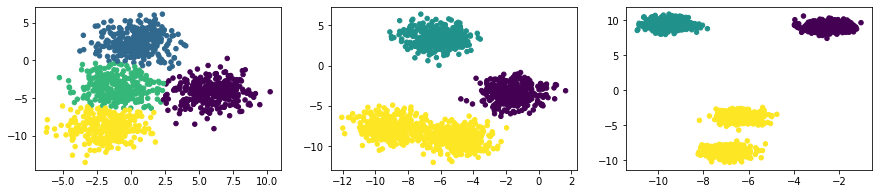

time: 1.05 s (started: 2021-05-30 20:08:07 +00:00)


In [53]:
plt.figure(figsize=(15,3))

plt.subplot(131)
plt.scatter(X1[:, 0], X1[:, 1], c=y1_kmeans_ours.collect(), s=20, cmap='viridis')

plt.subplot(132)
plt.scatter(X2[:, 0], X2[:, 1], c=y2_kmeans_ours.collect(), s=20, cmap='viridis')

plt.subplot(133)
plt.scatter(X3[:, 0], X3[:, 1], c=y3_kmeans_ours.collect(), s=20, cmap='viridis')

plt.savefig("ourKmeans.png")

## Evaluation des performances

In [31]:
print("NMI - Data1 - OurKmeans : " + str(normalized_mutual_info_score(y1_true, y1_kmeans_ours.collect())))
print("NMI - Data2 - OurKmeans : " + str(normalized_mutual_info_score(y2_true, y2_kmeans_ours.collect())))
print("NMI - Data3 - OurKmeans : " + str(normalized_mutual_info_score(y3_true, y3_kmeans_ours.collect())))

NMI - Data1 - OurKmeans : 0.8610095321297617
NMI - Data2 - OurKmeans : 0.800002462233379
NMI - Data3 - OurKmeans : 1.0
time: 107 ms (started: 2021-05-30 20:05:58 +00:00)


## Temps d'execution

In [54]:
%time pred1 = k_means(X1,4)

CPU times: user 1.17 s, sys: 94.9 ms, total: 1.27 s
Wall time: 5.56 s
time: 5.57 s (started: 2021-05-30 20:14:28 +00:00)


In [55]:
%time pred2 = k_means(X2,4)

CPU times: user 382 ms, sys: 34.6 ms, total: 417 ms
Wall time: 1.62 s
time: 1.62 s (started: 2021-05-30 20:14:34 +00:00)


In [56]:
%time pred3 = k_means(X3,4)

CPU times: user 506 ms, sys: 41.3 ms, total: 547 ms
Wall time: 1.69 s
time: 1.69 s (started: 2021-05-30 20:14:36 +00:00)


# **Utilisation de l'implémentation pour un cas pertinent**

## Importation des données

In [57]:
import pandas as pd
dataset = pd.read_csv('data.csv')

time: 19.9 ms (started: 2021-05-30 20:14:37 +00:00)


## Imputation des valeurs manquantes

In [58]:
missing = dataset.isnull().sum()
missing_pourcent = dataset.isnull().sum()/dataset.shape[0]*100
dic = {
    'missing':missing,
    'missing_pourcent %':missing_pourcent
}
frame=pd.DataFrame(dic)
frame

,missing,missing_pourcent %
id,0,0.0
diagnosis,0,0.0
radius_mean,0,0.0
texture_mean,0,0.0
perimeter_mean,0,0.0
area_mean,0,0.0
smoothness_mean,0,0.0
compactness_mean,0,0.0
concavity_mean,0,0.0
concave points_mean,0,0.0


time: 29 ms (started: 2021-05-30 20:14:37 +00:00)


In [59]:
missingCols = frame[frame["missing"]!=0].index.to_list()
for col in missingCols:
  dataset[col] = dataset[col].fillna(dataset[col].mean()) 

time: 3.76 ms (started: 2021-05-30 20:14:37 +00:00)


In [60]:
idCol = "id"
dataset.drop([idCol], axis=1, inplace=True)
dataset.drop(['Unnamed: 32'], axis=1, inplace=True)

time: 21.3 ms (started: 2021-05-30 20:14:37 +00:00)


In [61]:
y_class = dataset['diagnosis'].replace({"B":0,"M":1})

time: 5.24 ms (started: 2021-05-30 20:14:38 +00:00)


In [62]:
dataset.drop(["diagnosis"], axis=1, inplace=True)

time: 4.04 ms (started: 2021-05-30 20:14:38 +00:00)


In [63]:
data = dataset.values.tolist()

time: 4.06 ms (started: 2021-05-30 20:14:38 +00:00)


## Application des différents k-means et comparaison

In [64]:
kmeans_sklearn = Kmeans_sklearn_algo(n_clusters=2) 
%time kmeans_sklearn.fit(data)

y_kmeans_sklearn = kmeans_sklearn.predict(data)
print("NMI - Data - Sklearn : " + str(normalized_mutual_info_score(np.array(y_class.tolist()), y_kmeans_sklearn)))

CPU times: user 59.6 ms, sys: 40.6 ms, total: 100 ms
Wall time: 61.4 ms
NMI - Data - Sklearn : 0.46479332792160793
time: 75.3 ms (started: 2021-05-30 20:14:38 +00:00)


In [65]:
t = totupleliste(np.array(data),y_class)
rdd = sc.parallelize(t)
df = rdd.toDF(deptColumns)

%time y_kmeans_spark = kmeans_spark(df)
y_kmeans_spark = list(y_kmeans_spark.select('prediction').toPandas()['prediction'])
print("NMI - Data - Spark : " + str(normalized_mutual_info_score(y_class, y_kmeans_spark)))

CPU times: user 85.4 ms, sys: 18.1 ms, total: 104 ms
Wall time: 3.21 s
NMI - Data - Spark : 0.2902697371070435
time: 3.5 s (started: 2021-05-30 20:14:38 +00:00)


In [66]:
y_kmeans_ours = k_means(data,k=2)
print("NMI - Data - Ours : " + str(normalized_mutual_info_score(np.array(y_class.tolist()), y_kmeans_ours.collect())))

NMI - Data - Ours : 0.46479332792160793
time: 2.37 s (started: 2021-05-30 20:14:41 +00:00)
